---
layout: default
title: "Deep Learning - CNN - Face verification"
categories: deeplearning
permalink: /ML40/
order: 40
comments: true
---

In [2]:
%pylab --no-import-all inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["mathtext.fontset"] = "cm"
from matplotlib.patches import Rectangle
from mpl_flow import Flow
import pandas as pd
from plot_ann import ann

Populating the interactive namespace from numpy and matplotlib


# Face Verification
Face recognition together with liveness detection is a technology that is increasingly used for authentication in different environments. In face recognition literature there is a distinction between **face verification** and **face recognition**. In the face verification problem the algorithm is given an input image as well as a Name or identification support of a person and the task is to verify whether the input image is that of the claimed person. This kind of problem is sometimes referred to as $1:1$ problem, where the algorithm compare one input picture with the store image associated to the claimed person. The face recognition problem is much harder as it needs to compare the input picture against a database of K persons and output the ID of the matching person in DB (if any). This is hence a $1:K$ problem as you need to compare one input picture with $K$ images.

## One-shot learning
The reason why face verification is a hard task is because it is what is called a one-shot learning problem. In other words your learning algorithm needs to recognize a person given just one example of the person's face, given an an input picture that is different each time and that can vary wildly (<a href="#fig:lightcond">figure below</a>).

![png](./data/img/lightconditions.png)

<i id="fig:lightcond">Effect of different light source directions on the pictures of the face of a person taken from the same exact angle and distance</i>

Building a system where each person is associated to a class and a classifier tries to match an input picture to the correct class would lead inevitably to failure since you only have one train example for each class. Furthermore, if a new person is added to the people that need to be verified, the algorithm would need to be retrained.

One-shot learning works instead by **learning a similarity function** that outputs the degree of difference $d$ between two input images. Ideally, for the same person we would like $d$ to be very small, while for two different people we would like $d$ to be large. For values of $d$ below a certain threshold $\tau$ (an hyperparameter) we would predict that the two input pictures belong to the same person, while for $d > \tau$, we would predict that the pictures belong to two different people.

$$
d(\small\text{img1},\small\text{img2})
$$

So a face verification algorithm works by taking as input a picture comparing it with all pictures in the database of verified people. For a person that is in the database, we expect that one comparison will return a small value of $d$. For a person that is not in the database, all comparison will hopefully return large values of $d$.

## Siamese network
An implementation of a network to compute the difference between two images is the **siamese network**. The basic compoenent of a siamese network is a clsasical processing of an image through some early convolutional layers and late fully connected layers. Sometimes the last hidden layer is fed to a softmax classifier, but in this case we are instead interested in the last hidden layer itself. In a typical siamese network this is composed of 128 units and encodes for information in the the input picture. Let's call this vector of 128 elements $f(x^{(1)})$ and think of it as an encoding of picture $x^{(1)}$ that represents the input image as a vector of 128 numbers. In a siamese neural network, different pictures are fed to the same neural network with the same weights in order to obtain their encoding in 128-dimensional vectors. Let's say that we input picture $x^{(2)}$ to the network and obtain $f(x^{(2)})$ (<a href="#fig:siamesenet">figure below</a>).

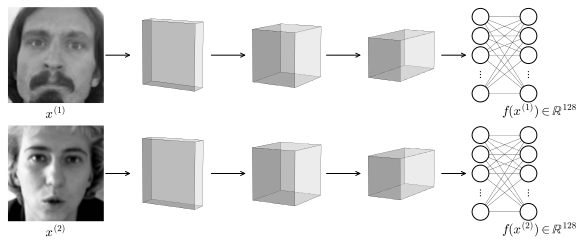

In [28]:
fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(2, 5)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
ax3 = fig.add_subplot(gs[0, 2], projection='3d')
ax4 = fig.add_subplot(gs[0, 3], projection='3d')
ax5 = fig.add_subplot(gs[0, 4])

ax7 = fig.add_subplot(gs[1, 0])
ax8 = fig.add_subplot(gs[1, 1], projection='3d')
ax9 = fig.add_subplot(gs[1, 2], projection='3d')
ax10 = fig.add_subplot(gs[1, 3], projection='3d')
ax11 = fig.add_subplot(gs[1, 4])

nrows = 2
faces = pd.read_csv('./data/face_landmarks.csv', nrows=nrows).Image

def row(rn, ax1, ax2, ax3, ax4, ax5):
    ax1.imshow(np.array(faces.iloc[rn].split(), dtype=int).reshape(96, 96), cmap='gray')
    ax1.set_axis_off()
    ax1.text(0.5, -.05, '$x^{{({})}}$'.format(rn+1), transform=ax1.transAxes, va='top', ha='center', fontsize=13)

    x, y, z = np.indices((1,1,1))
    voxels = (x >= 0) & (y >= 0) & (z >= 0)
    ax2.voxels(voxels, edgecolor='k', facecolors='w', linewidth=0.1, alpha=.4)
    ax2.set_box_aspect([28, 8, 28])

    ax3.voxels(voxels, edgecolor='k', facecolors='w', linewidth=0.1, alpha=.4)
    ax3.set_box_aspect([14, 16, 14])

    ax4.voxels(voxels, edgecolor='k', facecolors='w', linewidth=0.1, alpha=.4)
    ax4.set_box_aspect([10, 20, 10])

    ann([5, 5], ax=ax5, radius=2.5, node_labels=[*[*'   ', '$\\vdots$', ' ']*3], node_colors=list('kkkwk')*3, edge_colors=list('kkkwkkkkwkkkkwkwwwwwkkkwk'*3))
    ax5.set_aspect('equal')
    ax5.text(0.35, 0, '$f(x^{{({})}}) \\in \\mathbb{{R}}^{{128}}$'.format(rn+1), va='top', ha='left', fontsize=13)

    w1 = plt.annotate('', (1, 0.5), (.1, 0.5), xycoords=ax1.transAxes, textcoords=ax2.transAxes, arrowprops=dict(arrowstyle='<-'))
    w2 = plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax2.transAxes, textcoords=ax3.transAxes, arrowprops=dict(arrowstyle='<-'))
    w3 = plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax3.transAxes, textcoords=ax4.transAxes, arrowprops=dict(arrowstyle='<-'))
    w4 = plt.annotate('', (.9, 0.5), (0, 0.5), xycoords=ax4.transAxes, textcoords=ax5.transAxes, arrowprops=dict(arrowstyle='<-'))

    for ax in [ax2, ax3, ax4]:
        ax.view_init(elev=10, azim=120)
        ax.set_axis_off()

row(0, ax1, ax2, ax3, ax4, ax5)
row(1, ax7, ax8, ax9, ax10, ax11)

<i id="fig:siamesenet">siamese network</i>

Given $x^{(1)}, x^{(2)}, d(x^{(1)}), f(x^{(2)})$ we can define the distance between $^{(1)}$ and $x^{(2)}$ as the norm of the difference between the encodings of these two images.

$$
d(x^{(1)}, x^{(2)})=\left \| f(x^{(1)}) - f(x^{(2)})  \right \|_2^2
$$

The idea of running two identical CONV networks on two different inputs and compare their output is sometimes called **siamese network architecture** from [this research article](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Taigman_DeepFace_Closing_the_2014_CVPR_paper.pdf).

More formally and succinctly, the idea of a siamese network for face verification is that:

* The network is trained so that its parameters define an encoding $f(x^{i}) \in \mathbb{R}^{128}$
* The parameters are learned so that:
    * if $x^{(i)},x^{(j)}$ are the same person, $\left \| f(x^{(1)}) - f(x^{(2)})  \right \|_2^2$ is small
    * if $x^{(i)},x^{(j)}$ are different persons, $\left \| f(x^{(1)}) - f(x^{(2)})  \right \|_2^2$ is large

## Triplet loss
In order to train a network to produce a good enconding of a person face the **triplet loss** function works particularly well. Our learning objective is to compute the distance between two images: the picture that will identify one person in the final algorithm (also called the anchor) and an input picture. If the input picture is a positive example (belongs to the same person as the anchor) the distance needs to be small. If the input picture is a negative example the distance needs to be large. The reason why this.

$$
\begin{split}
& \underbrace{\left \| f(A) - f(P)  \right \|^2}_{d(A, P)} \leq \underbrace{\left \| f(A) - f(N)  \right \|^2}_{d(A, N)}\\
& \left \| f(A) - f(P)  \right \|^2 - \left \| f(A) - f(N)  \right \|^2 \leq 0 \\
\end{split}
$$

A trivial (but obviously undesired) way to satisfy this equation is if all images have identical encoding $f(x^{i})=k$, so we would have $(k-k)^2-(k-k)^2=0$. In order to prevent the network from learning that all images have identical encoding we need to modify the objective to

$$
 \left \| f(A) - f(P)  \right \|^2 - \left \| f(A) - f(N)  \right \|^2 \leq 0 - \alpha
$$

Which is usually found in the form

$$
\begin{equation}
 \left \| f(A) - f(P)  \right \|^2 - \left \| f(A) - f(N)  \right \|^2 + \alpha \leq 0 
\end{equation}
\label{eq:tripletlosscond} \tag{1}
$$

Where $\alpha$ is an hyperparameter called **margin** (reminiscent of SVM) that is used to prevent the network from learning trivial solutions by pushing further away the difference between $d(A,P)$ and $d(A,N)$.

More formally, the triple loss function is defined on triple on images: given three images $A, P$ and $N$ we can define the loss $\mathcal{L}$ as


$$
\mathcal{L}(A, P, N) = \max \left(\left \| f(A) - f(P)  \right \|^2 - \left \| f(A) - f(N)  \right \|^2 + \alpha, 0 \right)
$$

so that if the distance is $\leq 0$, than the loss $\mathcal{L}=0$, while if the distance is $> 0$, than the loss $\mathcal{L}>0$. The overall cost function $J$ for the neural network is 

$$
J = \sum_{i=1}^m \mathcal{L}\left(A^{(i)}, P^{(i)}, N^{(i)}\right)
$$

### Choosing the triplets A,P,N
For training the network the triplet loss function always require 3 pictures ($A, P, N$) and since A and P are pictures of the same person, this implies that the training set needs multiple pictures of the same person. For example, we could have a training set of 10,000 pictures of 1,000 people. To train the face verification model, we would need to select triplets from the training set to compute the triplet loss function.

Choosing the triplets from the training set is an important step in the training of our one-shot algorithm: If at training the triplets $A,P,N$ are chosen randomly, then the condition $\eqref{eq:tripletlosscond}$ (given that the picture enconding is reliable) is easily satisfied, thus the algorithm will not learn much from them. 

So in order to train the algorithm correctly, we should choose triplets that are hard to train on, in other words we should choose triplets for which $d(A, P) \approx d(A, N)$. If the triplets are chosen randomly, the gradient descent might take too long to get to acceptable performance, as shown in [this article](https://arxiv.org/abs/1503.03832).

Commercial face verification algorithms are trained on fairly large datasets, on the order of a million to 10 million images, with some talk to train on 100 million images.

## Face verification as a binary classification problem
Interestingly, [the article proposing the siamese network](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Taigman_DeepFace_Closing_the_2014_CVPR_paper.pdf), engineers similarity function learning as a binary classification problem instead that a triplet loss optimization problem.

Two identical networks taking part in a siamese network encode two different images and then merge in a logistic regression output unit with target output 1 if the two input images belong to the same person, and 0 if they belong to two different persons <a href="#fig:faceverbin">figure below</a>.

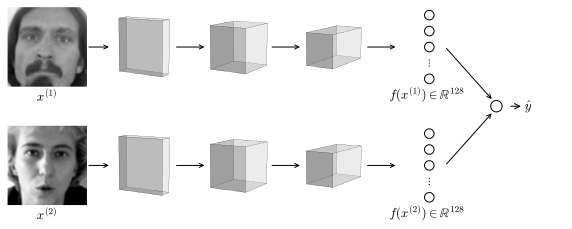

In [51]:
fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(2, 6)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
ax3 = fig.add_subplot(gs[0, 2], projection='3d')
ax4 = fig.add_subplot(gs[0, 3], projection='3d')
ax5 = fig.add_subplot(gs[0, 4])

ax7 = fig.add_subplot(gs[1, 0])
ax8 = fig.add_subplot(gs[1, 1], projection='3d')
ax9 = fig.add_subplot(gs[1, 2], projection='3d')
ax10 = fig.add_subplot(gs[1, 3], projection='3d')
ax11 = fig.add_subplot(gs[1, 4])

ax12 = fig.add_subplot(gs[:, 5])
ax12.set_axis_off()

nrows = 2
faces = pd.read_csv('./data/face_landmarks.csv', nrows=nrows).Image

def row(rn, ax1, ax2, ax3, ax4, ax5):
    ax1.imshow(np.array(faces.iloc[rn].split(), dtype=int).reshape(96, 96), cmap='gray')
    ax1.set_axis_off()
    ax1.text(0.5, -.05, '$x^{{({})}}$'.format(rn+1), transform=ax1.transAxes, va='top', ha='center', fontsize=13)

    x, y, z = np.indices((1,1,1))
    voxels = (x >= 0) & (y >= 0) & (z >= 0)
    ax2.voxels(voxels, edgecolor='k', facecolors='w', linewidth=0.1, alpha=.4)
    ax2.set_box_aspect([28, 8, 28])

    ax3.voxels(voxels, edgecolor='k', facecolors='w', linewidth=0.1, alpha=.4)
    ax3.set_box_aspect([14, 16, 14])

    ax4.voxels(voxels, edgecolor='k', facecolors='w', linewidth=0.1, alpha=.4)
    ax4.set_box_aspect([10, 20, 10])

    ann([5], ax=ax5, radius=1, node_labels=[*[*'   ', '$\\vdots$', ' ']*2], 
        node_colors=list('kkkwk')*2, edge_colors=list('kkkwkkkkwkkkkwkwwwwwkkkwk'*2))
    ax5.set_aspect('equal')
    ax5.set_xlim(-.5, .5)
    ax5.text(-.5, 0, '$f(x^{{({})}}) \\in \\mathbb{{R}}^{{128}}$'.format(rn+1), va='top', ha='left', fontsize=13)

    w1 = plt.annotate('', (1, 0.5), (.1, 0.5), xycoords=ax1.transAxes, textcoords=ax2.transAxes, arrowprops=dict(arrowstyle='<-'))
    w2 = plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax2.transAxes, textcoords=ax3.transAxes, arrowprops=dict(arrowstyle='<-'))
    w3 = plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax3.transAxes, textcoords=ax4.transAxes, arrowprops=dict(arrowstyle='<-'))
    w3 = plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax4.transAxes, textcoords=ax5.transAxes, arrowprops=dict(arrowstyle='<-'))

    for ax in [ax2, ax3, ax4]:
        ax.view_init(elev=10, azim=120)
        ax.set_axis_off()

ann([1], ax=ax12)
ax12.set_xlim(-.2, 1.2)
ax12.set_aspect('equal')
plt.annotate('', (.7, 0.5), (0.1, 0.6), xycoords=ax5.transAxes, textcoords=ax12.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('', (.7, 0.5), (0.1, 0.4), xycoords=ax11.transAxes, textcoords=ax12.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('$\\hat{y}$', (0.3, .5), (0.5, .5), xycoords=ax12.transAxes,
             textcoords=ax12.transAxes, arrowprops=dict(arrowstyle='<-'), va='center', fontsize=13)


row(0, ax1, ax2, ax3, ax4, ax5)
row(1, ax7, ax8, ax9, ax10, ax11)

<i id="fig:faceverbin">Face verification as a binary classification problem. A siamese network merge in a logistic regression unit that produces a binary output: 1 if the two inputs belong to the same person and 0 otherwise.</i>

In a binary classification implementation of the siamese network $\hat{y}$ is a non-linearity function applied to the encoding of the images

$$
\hat{y} = \sigma \left( \sum_{k=1}^{128} w_k S  +b \right)
$$

where $w_i$, $b$ are the trained parameters of the 128 features of the encodings to predict if the input pictures are of the same person or not and $S$ in the similarity function

$$
\begin{equation}
S=\left | f \left(x^{(i)} \right)_k - f \left(x^{(j)} \right)_k \right |
\end{equation}
\label{eq:binarysiamese} \tag{2}
$$

However $\eqref{eq:binarysiamese}$ is not the only way to compare the encodings, another possible way is by using the so called $\chi^2$ similarity

$$
S=\frac{\left (f \left(x^{(i)} \right)_k - f \left(x^{(j)} \right)_k \right)^2}{f \left(x^{(i)} \right)_k + f \left(x^{(j)} \right)_k}
$$